In [1]:
import os 
import zipfile
import json
import numpy as np

import random 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

import nltk
from collections import Counter
import pickle

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

import tqdm as tqdm

In [2]:
#!mkdir data_dir_coco

# download images and annotations to the data directory
#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir_coco/
#!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir_coco/
#!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir_coco/


#!pip install nltk
#!pip install pycocotools


In [3]:
def extract_files_zip(file,extract_dir):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(extract_dir)

In [4]:

root_path = os.getcwd()

file1 = root_path + "/data_dir_coco/annotations_trainval2014.zip"
file2 = root_path + "/data_dir_coco/train2014.zip"
file3 = root_path + "/data_dir_coco/val2014.zip"

#extract_files_zip(file1,root_path + "/data_dir_coco/")
#extract_files_zip(file2,root_path + "/data_dir_coco/")
#extract_files_zip(file3,root_path + "/data_dir_coco/")

# Get to Know the Dataset

In [5]:

ann_file = root_path+"/annotations/"

ann_file_name = os.listdir(ann_file)
ann_file_names = [ann_file + file for file in ann_file_name]

json_data = {}
for ann_file_name in ann_file_names:
    with open(ann_file_name, 'r') as file:
        data = json.load(file)
        json_data[ann_file_name.split('/')[-1][:-5]] = data

In [6]:
json_data.keys()

dict_keys(['captions_train2014', 'captions_val2014', 'instances_train2014', 'instances_val2014', 'person_keypoints_train2014', 'person_keypoints_val2014'])

In [7]:
json_data['captions_train2014']

{'info': {'description': 'COCO 2014 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2014,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'images': [{'license': 5,
   'file_name': 'COCO_train2014_000000057870.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-14 16:28:13',
   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
   'id': 57870},
  {'license': 5,
   'file_name': 'COCO_train2014_000000384029.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
   'height': 429,
   'width': 640,
   'date_captured': '2013-11-14 16:29:45',
   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
   'id': 384029},
  {'license': 1,
   'file_name': 'COCO_train2014_000000222016.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_tr

In [8]:
json_data['captions_train2014']['images']


[{'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870},
 {'license': 5,
  'file_name': 'COCO_train2014_000000384029.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'height': 429,
  'width': 640,
  'date_captured': '2013-11-14 16:29:45',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'id': 384029},
 {'license': 1,
  'file_name': 'COCO_train2014_000000222016.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg',
  'height': 640,
  'width': 480,
  'date_captured': '2013-11-14 16:37:59',
  'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg',
  'id': 222016},
 {'license': 3

In [9]:
json_data['captions_train2014']['annotations']

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'},
 {'image_id': 538480,
  'id': 288,
  'ca

In [10]:
train_img_list = {}

for img in json_data['captions_train2014']['images']:
    train_img_list[img['id']] = img['file_name']

In [11]:
sorted_train_img_list = dict(sorted(train_img_list.items()))
sorted_train_img_list

{9: 'COCO_train2014_000000000009.jpg',
 25: 'COCO_train2014_000000000025.jpg',
 30: 'COCO_train2014_000000000030.jpg',
 34: 'COCO_train2014_000000000034.jpg',
 36: 'COCO_train2014_000000000036.jpg',
 49: 'COCO_train2014_000000000049.jpg',
 61: 'COCO_train2014_000000000061.jpg',
 64: 'COCO_train2014_000000000064.jpg',
 71: 'COCO_train2014_000000000071.jpg',
 72: 'COCO_train2014_000000000072.jpg',
 77: 'COCO_train2014_000000000077.jpg',
 78: 'COCO_train2014_000000000078.jpg',
 81: 'COCO_train2014_000000000081.jpg',
 86: 'COCO_train2014_000000000086.jpg',
 89: 'COCO_train2014_000000000089.jpg',
 92: 'COCO_train2014_000000000092.jpg',
 94: 'COCO_train2014_000000000094.jpg',
 109: 'COCO_train2014_000000000109.jpg',
 110: 'COCO_train2014_000000000110.jpg',
 113: 'COCO_train2014_000000000113.jpg',
 127: 'COCO_train2014_000000000127.jpg',
 138: 'COCO_train2014_000000000138.jpg',
 142: 'COCO_train2014_000000000142.jpg',
 144: 'COCO_train2014_000000000144.jpg',
 149: 'COCO_train2014_000000000149

In [12]:
train_caption_list = {}
for cap in json_data['captions_train2014']['annotations']:
    train_caption_list[cap['image_id']] = cap['caption']
sorted_train_cap_list = dict(sorted(train_caption_list.items()))
sorted_train_cap_list

{9: 'A bunch of trays that have different food.',
 25: 'A giraffe standing next to a forest filled with trees.',
 30: 'A vase with red and white flowers outside on a sunny day.',
 34: 'a Zebra grazing on grass in a green open field.',
 36: 'A girl in a bathing suit with a pink umbrella.',
 49: 'Two costumed horse riders make their horses stand on their hind legs.',
 61: 'Several elephants in the jungle carrying people on their backs',
 64: 'A very pretty clock on the side of a road.',
 71: 'A train engine carrying many carts down a track.',
 72: 'The two giraffes appear to be hugging each other.',
 77: 'some male skateboarders are doing some tricks and grafitti',
 78: 'An owl candle and a clock sitting in front of a wall.',
 81: 'An Air France air plane in mid flight.',
 86: 'A man on a an old fashioned bicycle in the woods ',
 89: 'A stove top is cleaned with a set of knives on the wall.',
 92: 'A piece of chocolate dessert on a plate with a napkin and a fork.',
 94: 'A city street wi

In [13]:
assert (list(sorted_train_cap_list.keys()) == list(sorted_train_img_list.keys())) , 'The Keys do not Match'

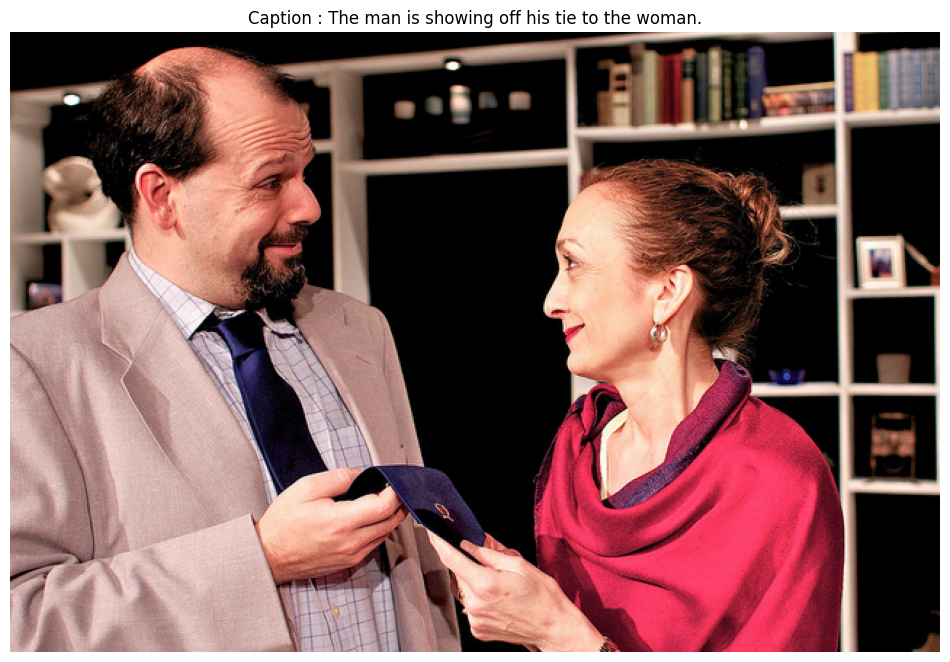

In [14]:

#random.seed(42)
chosen_img = random.choice(list(sorted_train_img_list.keys()))
img_root_path = root_path + "/data_dir_coco/train2014/"
img_path = sorted_train_img_list[chosen_img]
img_path = img_root_path+img_path
img_data = Image.open(img_path)

plt.figure(figsize = (12,12))
plt.imshow(img_data)
plt.axis('off')
plt.title(f'Caption : {sorted_train_cap_list[chosen_img]}')
plt.show()

# Tokenize the Words

In [15]:
#nltk.download('punkt')

In [16]:
nltk.data.path

['/home/rohanpattankar/nltk_data',
 '/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_master_pytorch/nltk_data',
 '/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_master_pytorch/share/nltk_data',
 '/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_master_pytorch/lib/nltk_data',
 '/usr/share/nltk_data',
 '/usr/local/share/nltk_data',
 '/usr/lib/nltk_data',
 '/usr/local/lib/nltk_data']

In [17]:
nltk.tokenize.word_tokenize(sorted_train_cap_list[chosen_img].lower())

['the', 'man', 'is', 'showing', 'off', 'his', 'tie', 'to', 'the', 'woman', '.']

In [18]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

In [19]:

def build_vocabulary(caption_list,threshold):
    counter = Counter()
    ids = list(caption_list.keys())
    for i,idx in enumerate(ids):
        caption = str(caption_list[idx])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1)%1000 == 0:
            print(f'Tokenized Tokens : {i+1}/{len(ids)}')
    
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
    
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

In [20]:
vocab = build_vocabulary(sorted_train_cap_list,threshold=4)

Tokenized Tokens : 1000/82783
Tokenized Tokens : 2000/82783
Tokenized Tokens : 3000/82783
Tokenized Tokens : 4000/82783
Tokenized Tokens : 5000/82783
Tokenized Tokens : 6000/82783
Tokenized Tokens : 7000/82783
Tokenized Tokens : 8000/82783
Tokenized Tokens : 9000/82783
Tokenized Tokens : 10000/82783
Tokenized Tokens : 11000/82783
Tokenized Tokens : 12000/82783
Tokenized Tokens : 13000/82783
Tokenized Tokens : 14000/82783
Tokenized Tokens : 15000/82783
Tokenized Tokens : 16000/82783
Tokenized Tokens : 17000/82783
Tokenized Tokens : 18000/82783
Tokenized Tokens : 19000/82783
Tokenized Tokens : 20000/82783
Tokenized Tokens : 21000/82783
Tokenized Tokens : 22000/82783
Tokenized Tokens : 23000/82783
Tokenized Tokens : 24000/82783
Tokenized Tokens : 25000/82783
Tokenized Tokens : 26000/82783
Tokenized Tokens : 27000/82783
Tokenized Tokens : 28000/82783
Tokenized Tokens : 29000/82783
Tokenized Tokens : 30000/82783
Tokenized Tokens : 31000/82783
Tokenized Tokens : 32000/82783
Tokenized Tokens 

In [21]:
vocab.i2w

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: 'a',
 5: 'bunch',
 6: 'of',
 7: 'trays',
 8: 'that',
 9: 'have',
 10: 'different',
 11: 'food',
 12: '.',
 13: 'giraffe',
 14: 'standing',
 15: 'next',
 16: 'to',
 17: 'forest',
 18: 'filled',
 19: 'with',
 20: 'trees',
 21: 'vase',
 22: 'red',
 23: 'and',
 24: 'white',
 25: 'flowers',
 26: 'outside',
 27: 'on',
 28: 'sunny',
 29: 'day',
 30: 'zebra',
 31: 'grazing',
 32: 'grass',
 33: 'in',
 34: 'green',
 35: 'open',
 36: 'field',
 37: 'girl',
 38: 'bathing',
 39: 'suit',
 40: 'pink',
 41: 'umbrella',
 42: 'two',
 43: 'costumed',
 44: 'horse',
 45: 'riders',
 46: 'make',
 47: 'their',
 48: 'horses',
 49: 'stand',
 50: 'hind',
 51: 'legs',
 52: 'several',
 53: 'elephants',
 54: 'the',
 55: 'jungle',
 56: 'carrying',
 57: 'people',
 58: 'backs',
 59: 'very',
 60: 'pretty',
 61: 'clock',
 62: 'side',
 63: 'road',
 64: 'train',
 65: 'engine',
 66: 'many',
 67: 'carts',
 68: 'down',
 69: 'track',
 70: 'giraffes',
 71: 'appear',
 72:

In [22]:
save_path = root_path + "/data_dir_coco/vocab.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(save_path))

Total vocabulary size: 4955
Saved the vocabulary wrapper to '/mnt/f/Rohan/Ubuntu_2204/projects/mastering_pytorch/data_dir_coco/vocab.pkl'


# Resize Images

In [23]:
def reshape_images(image_path,output_path,reshape_shape):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = image.resize(reshape_shape,Image.LANCZOS)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1)%1000 == 0:
            print(f'Images Saved : {i+1}/{num_im}')

In [24]:
image_path = root_path + '/data_dir_coco/train2014/'
output_path =root_path + '/data_dir_coco/resized_images/'
image_shape = [256, 256]
#reshape_images(image_path, output_path, image_shape)

# Create custom Dataset

In [28]:

class CustomCocoDataset(Dataset):
    """Caption dataset."""

    def __init__(self, image_path, caption_list, image_list,vocabulary, cap_lens,transform=None):
        """
        Arguments:
            image_path (string): The directory were the original images are stored
            caption_list(string): The dictionary containing id's as keys and caption as values 
            image_list : The dictionary containing id's as keys and image path
            vocabulary : The files containing index values for words
            cap_lens : Maximum length of the caption
            transform (callable, optional): Optional transform to be applied on a sample.
            
        """
        self.image_path = image_path
        self.vocabulary = vocabulary
        self.caption_list = caption_list
        self.transform = transform
        self.image_list = image_list
        self.indices = list(self.caption_list.keys())
        self.cap_lens = cap_lens

    def __len__(self):
        return len(self.caption_list)

    def __getitem__(self, idx):
        
        annotation_id = self.indices[idx]
        caption = self.caption_list[annotation_id]
        img_path = self.image_list[annotation_id]
        image = Image.open(os.path.join(self.image_path, img_path)).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)

        #Convert caption to word ids
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        #word_tokens = word_tokens[:self.cap_lens]
        captions = []
        captions.append(self.vocabulary('<start>'))
        captions.extend([self.vocabulary(token) for token in word_tokens])
        captions.append(self.vocabulary('<end>'))
        # tgts = torch.zeros(self.cap_lens).long()
        # ground_truth = torch.Tensor(captions)
        # if len(ground_truth) < self.cap_lens:
        #     tgts[:len(ground_truth)] = ground_truth
        # else:
        #     tgts = ground_truth[:self.cap_lens]
        
        return image, captions

#Maximum length of the Caption in the train dataset
val_caps = sorted_train_cap_list.values()
len_caps = []
for val_cap in val_caps:
    len_caps.append(len(val_cap.split()))
cap_lens = max(len_caps)

# Image preprocessing, normalization for the pretrained resnet
transform_prep = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

coco_dataset = CustomCocoDataset(output_path,sorted_train_cap_list,sorted_train_img_list,vocab, cap_lens=cap_lens, transform=transform_prep)

In [31]:
#Building a Custom Dataloader with Input 
import torch.nn.utils.rnn as rnn_utils
batch_size = 256
shuffle = True

def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = torch.LongTensor(cap[:end] )       
    return imgs, tgts, cap_lens

def collate_fn(data):
    """Collate function to handle variable-length captions."""
    imgs, caps, lens = zip(*data)

    # Stack images (assuming they are already the same size)
    imgs = torch.stack(imgs, dim=0)

    # Pad captions
    caps_padded = rnn_utils.pad_sequence(caps, batch_first=True)
    
    return imgs, caps_padded, torch.tensor(lens)

custom_data_loader = torch.utils.data.DataLoader(dataset = coco_dataset,batch_size=batch_size,shuffle=shuffle,collate_fn = collate_function)

In [32]:
# get some random training images
dataiter = iter(custom_data_loader)
images, labels, cap_lens = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


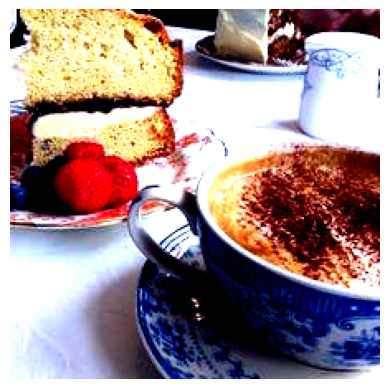

In [33]:
def plot_images(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

plot_images(images[0])

# Building the Model

In [34]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(weights=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        capts = capts.long()
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True,enforce_sorted=False)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

# Training the Model

In [41]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model directory
if not os.path.exists('data_dir_coco/models_dir/'):
    os.makedirs('data_dir_coco/models_dir/')

# Load vocabulary wrapper
with open(root_path + '/data_dir_coco/vocab.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

#Training Loops
epochs = 5
total_num_steps = len(custom_data_loader)
for epoch in tqdm.tqdm(range(epochs)):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
                
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True,enforce_sorted=False)[0]
        
        #Forward Pass, Backward Pass and Optimize
        img_embds = encoder_model(imgs)
        outputs = decoder_model(img_embds,caps,lens)
        if outputs.size(0) != tgts.size(0):  # Check if they match
            # Handle the mismatch
            min_size = min(outputs.size(0), tgts.size(0))
            outputs = outputs[:min_size]  # Truncate the output if necessary
            tgts = tgts[:min_size]  # Truncate the targets if necessary
        
        loss = loss_criterion(outputs, tgts.long())
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, epochs, i, total_num_steps, loss.item(), np.exp(loss.item()))) 

        # Save the model checkpoints
        if (i+1) % 300 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                root_path + '/data_dir_coco/models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                root_path + '/data_dir_coco/models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


  0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Epoch [0/5], Step [0/324], Loss: 8.5205, Perplexity: 5016.5719
Epoch [0/5], Step [20/324], Loss: 4.9715, Perplexity: 144.2360
Epoch [0/5], Step [40/324], Loss: 4.3421, Perplexity: 76.8666
Epoch [0/5], Step [60/324], Loss: 3.9524, Perplexity: 52.0612
Epoch [0/5], Step [80/324], Loss: 3.8435, Perplexity: 46.6875
Epoch [0/5], Step [100/324], Loss: 3.6954, Perplexity: 40.2626
Epoch [0/5], Step [120/324], Loss: 3.5463, Perplexity: 34.6831
Epoch [0/5], Step [140/324], Loss: 3.3914, Perplexity: 29.7071
Epoch [0/5], Step [160/324], Loss: 3.3285, Perplexity: 27.8957
Epoch [0/5], Step [180/324], Loss: 3.1893, Perplexity: 24.2707
Epoch [0/5], Step [200/324], Loss: 3.1636, Perplexity: 23.6558
Epoch [0/5], Step [220/324], Loss: 3.2625, Perplexity: 26.1151
Epoch [0/5], Step [240/324], Loss: 2.9679, Perplexity: 19.4504
Epoch [0/5], Step [260/324], Loss: 3.1410, Perplexity: 23.1264
Epoch [0/5], Step [280/324], Loss: 2.9530, Perplexity: 19.1642
Epoch [0/5], Step [300/324], Loss: 2.9374, Perplexity: 18.

 20%|██████████████▍                                                         | 1/5 [08:34<34:19, 514.89s/it]

Epoch [1/5], Step [0/324], Loss: 2.9202, Perplexity: 18.5445
Epoch [1/5], Step [20/324], Loss: 2.8882, Perplexity: 17.9601
Epoch [1/5], Step [40/324], Loss: 2.8484, Perplexity: 17.2594
Epoch [1/5], Step [60/324], Loss: 2.7912, Perplexity: 16.3009
Epoch [1/5], Step [80/324], Loss: 2.7691, Perplexity: 15.9437
Epoch [1/5], Step [100/324], Loss: 2.6703, Perplexity: 14.4437
Epoch [1/5], Step [120/324], Loss: 2.7501, Perplexity: 15.6438
Epoch [1/5], Step [140/324], Loss: 2.8297, Perplexity: 16.9405
Epoch [1/5], Step [160/324], Loss: 2.5533, Perplexity: 12.8498
Epoch [1/5], Step [180/324], Loss: 2.6927, Perplexity: 14.7708
Epoch [1/5], Step [200/324], Loss: 2.6880, Perplexity: 14.7017
Epoch [1/5], Step [220/324], Loss: 2.5831, Perplexity: 13.2381
Epoch [1/5], Step [240/324], Loss: 2.5484, Perplexity: 12.7864
Epoch [1/5], Step [260/324], Loss: 2.6241, Perplexity: 13.7922
Epoch [1/5], Step [280/324], Loss: 2.6234, Perplexity: 13.7820
Epoch [1/5], Step [300/324], Loss: 2.6917, Perplexity: 14.757

 40%|████████████████████████████▊                                           | 2/5 [16:37<24:47, 495.67s/it]

Epoch [2/5], Step [0/324], Loss: 2.4946, Perplexity: 12.1174
Epoch [2/5], Step [20/324], Loss: 2.4931, Perplexity: 12.0987
Epoch [2/5], Step [40/324], Loss: 2.4726, Perplexity: 11.8536
Epoch [2/5], Step [60/324], Loss: 2.4223, Perplexity: 11.2721
Epoch [2/5], Step [80/324], Loss: 2.3530, Perplexity: 10.5172
Epoch [2/5], Step [100/324], Loss: 2.4305, Perplexity: 11.3640
Epoch [2/5], Step [120/324], Loss: 2.4313, Perplexity: 11.3736
Epoch [2/5], Step [140/324], Loss: 2.4235, Perplexity: 11.2856
Epoch [2/5], Step [160/324], Loss: 2.5140, Perplexity: 12.3539
Epoch [2/5], Step [180/324], Loss: 2.3835, Perplexity: 10.8432
Epoch [2/5], Step [200/324], Loss: 2.4856, Perplexity: 12.0084
Epoch [2/5], Step [220/324], Loss: 2.3995, Perplexity: 11.0176
Epoch [2/5], Step [240/324], Loss: 2.3684, Perplexity: 10.6803
Epoch [2/5], Step [260/324], Loss: 2.4803, Perplexity: 11.9453
Epoch [2/5], Step [280/324], Loss: 2.4704, Perplexity: 11.8266
Epoch [2/5], Step [300/324], Loss: 2.3739, Perplexity: 10.738

 60%|███████████████████████████████████████████▏                            | 3/5 [24:37<16:17, 488.81s/it]

Epoch [3/5], Step [0/324], Loss: 2.2595, Perplexity: 9.5778
Epoch [3/5], Step [20/324], Loss: 2.3705, Perplexity: 10.7026
Epoch [3/5], Step [40/324], Loss: 2.3612, Perplexity: 10.6032


 60%|███████████████████████████████████████████▏                            | 3/5 [26:21<17:34, 527.01s/it]


KeyboardInterrupt: 

# Predict Output for a Random Image

/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_master_pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_6799/1723431746.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob

a man in a baseball uniform standing on a field .


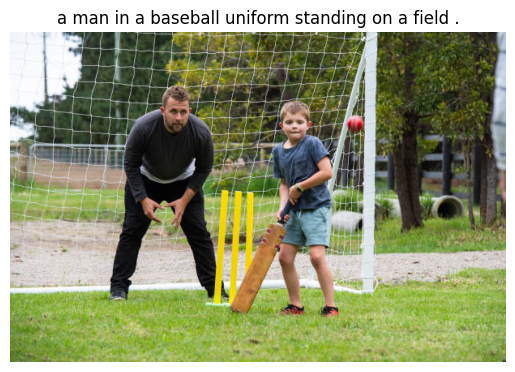

In [48]:
image_file_path = 'sample.jpg'
 
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open(root_path + '/data_dir_coco/vocab.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-3-300.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-3-300.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_caption = predicted_caption[1:-1]
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.title(predicted_sentence)
plt.axis('off')
plt.imshow(np.asarray(img))
plt.savefig('predicted.png')